[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Miyake_et_al_1968/fig_19.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Miyake_et_al_1968/fig_19.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Miyake_et_al_1968/fig_19.ipynb)

#### based on Fig. 19 from Miyake et al. 1968  "_An Isotopic Study on Meteoric Precipitation_"
https://doi.org/10.2467/mripapers1950.19.2_243

Notes:
- extended to cover Oxygen-17
- different ventilation coefficients depicted (neglect, Froessling, Prupparcher & Rasmussen)
- different diffusivity ratios used for different isotopes (with D_heavy/D approximated with D_heavy/D_light), visible but insignificant differences

In [5]:
import numpy as np
from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.physics.constants_defaults import T0
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [6]:
VENTILATION_VARIANTS = ('Neglect', 'Froessling1938', 'PruppacherAndRasmussen1979')
AIR_DENSITY = 1 * si.kg / si.m**3

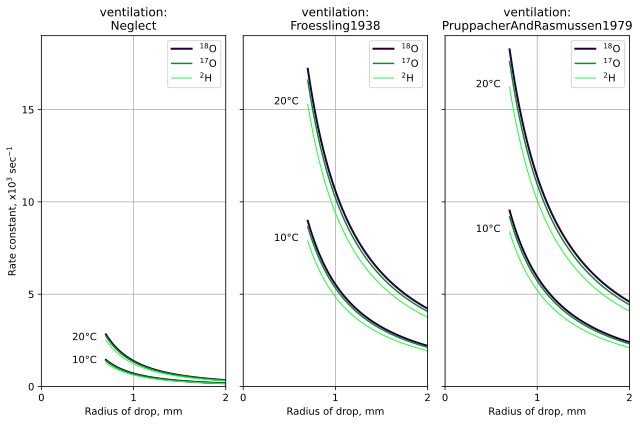

HTML(value="<a href='./fig_19.pdf' target='_blank'>./fig_19.pdf</a><br>")

In [9]:
fig, axs = pyplot.subplots(1, len(VENTILATION_VARIANTS), figsize=(9, 6), sharey=True, tight_layout=True)

radii = np.linspace(.7, 2) * si.mm
plot_x = in_unit(radii, si.mm)
plot_y = {}

for ax_i, ventilation_variant in enumerate(VENTILATION_VARIANTS):
    FORMULAE = Formulae(
        isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994+BarkanAndLuz2005',
        ventilation=ventilation_variant,
        terminal_velocity='RogersYau',
        diffusion_thermics='GrabowskiEtAl2011',
        isotope_relaxation_timescale='MiyakeEtAl1968',
        isotope_diffusivity_ratios='HellmannAndHarvey2020',
    )
    CONST = FORMULAE.constants
    for temperature in (T0 + 20 * si.K, T0 + 10 * si.K):
        for color_i, iso in enumerate(('18O', '17O', '2H')):
            e_s = FORMULAE.saturation_vapour_pressure.pvs_Celsius(temperature - T0)
            
            M_iso = getattr(CONST, f'M_{iso}') + CONST.M_1H + (CONST.M_1H if iso[-1] == 'O' else CONST.M_16O)
    
            alpha_fun = getattr(
                FORMULAE.isotope_equilibrium_fractionation_factors,
                f'alpha_l_{iso}'
            )
            if iso == '17O':
                alpha_l_18O = FORMULAE.isotope_equilibrium_fractionation_factors.alpha_l_18O(temperature)
                alpha_iso = alpha_fun(np.nan, alpha_l_18O)
            else:
                alpha_iso = alpha_fun(temperature)
            
            D = (
                FORMULAE.diffusion_thermics.D(temperature, np.nan)
                * getattr(FORMULAE.isotope_diffusivity_ratios, f'ratio_{iso}')(temperature)
            )

            dynamic_viscosity = FORMULAE.air_dynamic_viscosity.eta_air(temperature)
            Sc = FORMULAE.trivia.air_schmidt_number(dynamic_viscosity, D, AIR_DENSITY)
            Re = FORMULAE.particle_shape_and_density.reynolds_number(
                radii,
                FORMULAE.terminal_velocity.v_term(radii),
                dynamic_viscosity,
                AIR_DENSITY
            )
                
            vent_coeff = FORMULAE.ventilation.ventilation_coefficient(FORMULAE.trivia.sqrt_re_times_cbrt_sc(Re, Sc))
            tau = FORMULAE.isotope_relaxation_timescale.tau(e_s, D, M_iso, vent_coeff, radii, alpha_iso, temperature)
            key = f"{ventilation_variant}-{temperature}-{iso}"
            plot_y[key] = in_unit(1/tau, 1 / si.ks)
            axs[ax_i].plot(
                plot_x,
                plot_y[key],
                color=(.111, color_i/2, .222),
                linewidth=2 - color_i/2,
                label=f"$^{{{iso[:-1]}}}${iso[-1]}" if temperature == T0 + 10 * si.K else ''
            )
        axs[ax_i].annotate(f"{temperature-T0:g}°C", (radii[0]+.333, plot_y[key][0]))
    axs[ax_i].set_title(f"ventilation:\n{ventilation_variant}")
    axs[ax_i].set_ylim(0, 19)
    axs[ax_i].set_yticks(np.linspace(0, 15, 4))
    axs[ax_i].set_xlim(0, 2)
    axs[ax_i].set_xticks(np.linspace(0, 2, 3))
    axs[ax_i].set_xlabel('Radius of drop, mm')
    axs[ax_i].grid()
    axs[ax_i].legend()
    if ax_i == 0:
        axs[ax_i].set_ylabel('Rate constant, x10$^3$ sec$^{-1}$')
show_plot('fig_19.pdf')